## Load packages

In [48]:
setwd("~/meetup")

library(caret)
library(ggplot2)
library(dplyr)
library(tidyr)
library(doMC)
library(randomForest)
library(pROC)
library(ROCR)

#set number of cores 
registerDoMC(4)

## Import Data

In [8]:
airline <- read.csv("meetup_data/train-0.1m.csv")

In [9]:
#clean the feature names, change "c-" to "c_".  (this was causing issues during vectorization)
airline$DayOfWeek <- gsub("c-","c_",airline$DayOfWeek)
airline$DayOfWeek <- as.factor(airline$DayOfWeek)
airline$DayofMonth <- gsub("c-","c_",airline$DayofMonth)
airline$DayofMonth <- as.factor(airline$DayofMonth)
airline$Month <- gsub("c-","c_",airline$Month)
airline$Month <- as.factor(airline$Month)

## Data Exploration

In [10]:
head(airline)

,Year,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
1,2006,c_11,c_22,c_3,1316,AA,FAT,DFW,1313,N
2,2004,c_10,c_12,c_2,1242,US,SAN,PHL,2369,N
3,2006,c_5,c_5,c_5,1302,OO,SBP,SFO,191,Y
4,2005,c_8,c_8,c_1,1138,DL,PHL,ATL,665,N
5,2005,c_4,c_3,c_7,1438,DL,ATL,BDL,859,N
6,2005,c_9,c_15,c_4,2311,OH,ATL,EVV,350,N


In [11]:
summary(as.factor(airline$Year))

2004  2005  2006  2007 
24767 24914 24600 25719

In [12]:
summary(airline$Month)

c_1 c_10 c_11 c_12  c_2  c_3  c_4  c_5  c_6  c_7  c_8  c_9 
8054 8544 8147 8278 7551 8606 8199 8414 8516 8828 8781 8082

In [13]:
summary(airline$UniqueCarrier)

9E    AA    AQ    AS    B6    CO    DH    DL    EV    F9    FL    HA    HP 
  888  9164   291  2247  1910  4281  1449  8161  3958   862  3070   721  1366 
   MQ    NW    OH    OO    TZ    UA    US    WN    XE    YV 
 7133  6332  4246  7274   519  6985  6380 15006  5744  2013

In [14]:
summary(airline$Distance)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   27.0   316.0   563.0   723.1   950.0  4962.0 

## Vectorizing

In [15]:
airline_vec <-  model.matrix(dep_delayed_15min ~ ., data = airline)

In [16]:
head(airline_vec)

,(Intercept),Year,Monthc_10,Monthc_11,Monthc_12,Monthc_2,Monthc_3,Monthc_4,Monthc_5,Monthc_6,Monthc_7,Monthc_8,Monthc_9,DayofMonthc_10,DayofMonthc_11,DayofMonthc_12,DayofMonthc_13,DayofMonthc_14,DayofMonthc_15,DayofMonthc_16,DayofMonthc_17,DayofMonthc_18,DayofMonthc_19,DayofMonthc_2,DayofMonthc_20,DayofMonthc_21,DayofMonthc_22,DayofMonthc_23,DayofMonthc_24,DayofMonthc_25,DayofMonthc_26,DayofMonthc_27,DayofMonthc_28,DayofMonthc_29,DayofMonthc_3,DayofMonthc_30,DayofMonthc_31,DayofMonthc_4,DayofMonthc_5,DayofMonthc_6,DayofMonthc_7,DayofMonthc_8,DayofMonthc_9,DayOfWeekc_2,DayOfWeekc_3,DayOfWeekc_4,DayOfWeekc_5,DayOfWeekc_6,DayOfWeekc_7,DepTime,UniqueCarrierAA,UniqueCarrierAQ,UniqueCarrierAS,UniqueCarrierB6,UniqueCarrierCO,UniqueCarrierDH,UniqueCarrierDL,UniqueCarrierEV,UniqueCarrierF9,UniqueCarrierFL,UniqueCarrierHA,UniqueCarrierHP,UniqueCarrierMQ,UniqueCarrierNW,UniqueCarrierOH,UniqueCarrierOO,UniqueCarrierTZ,UniqueCarrierUA,UniqueCarrierUS,UniqueCarrierWN,UniqueCarrierXE,UniqueCarrierYV,OriginABI,OriginABQ,OriginABY,OriginACK,OriginACT,OriginACV,OriginACY,OriginADK,OriginADQ,OriginAEX,OriginAGS,OriginAKN,OriginALB,OriginALO,OriginAMA,OriginANC,OriginAPF,OriginASE,OriginATL,OriginATW,OriginAUS,OriginAVL,OriginAVP,OriginAZO,OriginBDL,OriginBET,OriginBFL,OriginBGM,OriginBGR,OriginBHM,OriginBIL,OriginBIS,OriginBJI,OriginBLI,OriginBMI,OriginBNA,OriginBOI,OriginBOS,OriginBPT,OriginBQK,OriginBQN,OriginBRO,OriginBRW,OriginBTM,OriginBTR,OriginBTV,OriginBUF,OriginBUR,OriginBWI,OriginBZN,OriginCAE,OriginCAK,OriginCDC,OriginCDV,OriginCEC,OriginCHA,OriginCHO,OriginCHS,OriginCIC,OriginCID,OriginCLD,OriginCLE,OriginCLL,OriginCLT,OriginCMH,OriginCMI,OriginCOD,OriginCOS,OriginCPR,OriginCRP,OriginCRW,OriginCSG,OriginCVG,OriginCWA,OriginDAB,OriginDAL,OriginDAY,OriginDBQ,OriginDCA,OriginDEN,OriginDFW,OriginDHN,OriginDLG,OriginDLH,OriginDRO,OriginDSM,OriginDTW,OriginEAU,OriginEGE,OriginEKO,OriginELM,OriginELP,OriginERI,OriginEUG,OriginEVV,OriginEWN,OriginEWR,OriginEYW,OriginFAI,OriginFAR,OriginFAT,OriginFAY,OriginFCA,OriginFLG,OriginFLL,OriginFLO,OriginFNT,OriginFSD,OriginFSM,OriginFWA,OriginGEG,OriginGFK,OriginGGG,OriginGJT,OriginGNV,OriginGPT,OriginGRB,OriginGRK,OriginGRR,OriginGSO,OriginGSP,OriginGTF,OriginGTR,OriginGUC,OriginHDN,OriginHHH,OriginHKY,OriginHLN,OriginHNL,OriginHOU,OriginHPN,OriginHRL,OriginHSV,OriginHTS,OriginHVN,OriginIAD,OriginIAH,OriginICT,OriginIDA,OriginILE,OriginILG,OriginILM,OriginIND,OriginINL,OriginIPL,OriginISO,OriginISP,OriginITO,OriginIYK,OriginJAC,OriginJAN,OriginJAX,OriginJFK,OriginJNU,OriginKOA,OriginKTN,OriginLAN,OriginLAS,OriginLAW,OriginLAX,OriginLBB,OriginLCH,OriginLEX,OriginLFT,OriginLGA,OriginLGB,OriginLIH,OriginLIT,OriginLNK,OriginLNY,OriginLRD,OriginLSE,OriginLWB,OriginLWS,OriginLYH,OriginMAF,OriginMBS,OriginMCI,OriginMCN,OriginMCO,OriginMDT,OriginMDW,OriginMEI,OriginMEM,OriginMFE,OriginMFR,OriginMGM,OriginMHT,OriginMIA,OriginMKE,OriginMKK,OriginMLB,OriginMLI,OriginMLU,OriginMOB,OriginMOD,OriginMOT,OriginMQT,OriginMRY,OriginMSN,OriginMSO,OriginMSP,OriginMSY,OriginMTJ,OriginMYR,OriginOAJ,OriginOAK,OriginOGG,OriginOKC,OriginOMA,OriginOME,OriginONT,OriginORD,OriginORF,OriginOTZ,OriginOXR,OriginPBI,OriginPDX,OriginPFN,OriginPHF,OriginPHL,OriginPHX,OriginPIA,OriginPIE,OriginPIH,OriginPIT,OriginPLN,OriginPMD,OriginPNS,OriginPSC,OriginPSE,OriginPSG,OriginPSP,OriginPVD,OriginPWM,OriginRAP,OriginRDD,OriginRDM,OriginRDU,OriginRFD,OriginRHI,OriginRIC,OriginRNO,OriginROA,OriginROC,OriginROW,OriginRST,OriginRSW,OriginSAN,OriginSAT,OriginSAV,OriginSBA,OriginSBN,OriginSBP,OriginSCC,OriginSCE,OriginSDF,OriginSEA,OriginSFO,OriginSGF,OriginSGU,OriginSHV,OriginSIT,OriginSJC,OriginSJT,OriginSJU,OriginSLC,OriginSLE,OriginSMF,OriginSMX,OriginSNA,OriginSOP,OriginSPI,OriginSPS,OriginSRQ,OriginSTL,OriginSTT,OriginSTX,OriginSUN,OriginSUX,OriginSWF,OriginSYR,OriginTEX,OriginTLH,OriginTOL,OriginTPA,OriginTRI,OriginTTN,OriginTUL,OriginTUP,OriginTUS,OriginTVC,OriginTWF,OriginTXK,OriginTYR,OriginTYS,OriginVCT,OriginVIS,OriginVLD,OriginVPS,

In [17]:
#remove "intercept"
airline_vec <- airline_vec[,-1]

In [18]:
airline_vec <- as.data.frame(airline_vec)

In [20]:
airline_vec$dep_delayed_15min <- airline$dep_delayed_15min

## Splitting data into train, test and (out-of-time) validation set¶

In [23]:
# use 2007 data as validation set
# divide other data into train and test
airline_vec_prior_2007 <- airline_vec %>% filter(Year < 2007)
airline_vec_2007 <- airline_vec %>% filter(Year == 2007)

In [27]:
# splite train and test (ratio 0.6:0.4)
set.seed(3456)
trainIndex <- createDataPartition(airline_vec_prior_2007$dep_delayed_15min, p = .6,
                                  list = FALSE,
                                  times = 1)
head(trainIndex)
airlineTrain <- airline_vec_prior_2007[ trainIndex,]
print(paste0("Number of obs in training: ",nrow(airlineTrain)))
airlineTest  <- airline_vec_prior_2007[-trainIndex,]
print(paste0("Number of obs in test: ",nrow(airlineTest)))

Resample1
5
6
7
9
11
13


[1] "Number of obs in training: 44569"
[1] "Number of obs in test: 29712"


## Take 10k random sample

In [29]:
#take 10K random sample for grid search
idx_10k <- sample(nrow(airline_vec_prior_2007),1e4)
airline_10k <- airline_vec_prior_2007[idx_10k,]
#Split 10k sample into training, and test
idx_10k_train <- sample(nrow(airline_10k),floor(nrow(airline_10k)*.75))
airline_train_10k <- airline_10k[idx_10k_train,]
airline_test_10k <- airline_10k[-idx_10k_train,]
print(paste0("Number of obs in training: ",nrow(airline_train_10k)))
print(paste0("Number of obs in training: ",nrow(airline_test_10k)))

[1] "Number of obs in training: 7500"
[1] "Number of obs in training: 2500"


## Grid Search with Caret

The only tuning parameter for random forest with caret default grid search is mtry. But you can adjust ntrees, sampsize and other tuning parameters in RandomForest pacakge explicity. Or you can write your own customized caret grid search to do that. (You may refer to this post :http://machinelearningmastery.com/tune-machine-learning-algorithms-in-r/)

In [30]:
myGrid = expand.grid(mtry = c(1:5)*20)

set.seed(77)
cv_build_fold_idx <- createMultiFolds(airline_train_10k$dep_delayed_15min, k = 3, times = 1)

model_vars <- names(airline_train_10k)[!names(airline_train_10k)%in% c('dep_delayed_15min','(Intercept)')]

#set up your caret fit control, we use 3-fold CV with no repeat here
cvFitControl <- trainControl(method = "repeatedcv", repeats = 1, number = 3, index = cv_build_fold_idx,
                             classProbs = TRUE, summaryFunction = twoClassSummary, returnResamp = 'all', savePredictions = T,
                             allowParallel= T, verboseIter = T)

start = Sys.time()
model_rf <- train(reformulate(model_vars, response="dep_delayed_15min"), data = airline_train_10k, metric = "ROC", preProcess = NULL,
                  method = "rf", ntrees = 200, sampsize = c(70,70),tuneGrid = myGrid, trControl = cvFitControl, importance = T)

end = Sys.time()
duration = end - start
print(duration)

Aggregating results
Selecting tuning parameters
Fitting mtry = 60 on full training set
Time difference of 10.67876 mins


### Check your grid search CV results 

In [31]:
print(model_rf)

Random Forest 

7500 samples
 683 predictor
   2 classes: 'N', 'Y' 

No pre-processing
Resampling: Cross-Validated (3 fold, repeated 1 times) 
Summary of sample sizes: 5000, 5000, 5000 
Resampling results across tuning parameters:

  mtry  ROC        Sens       Spec       ROC SD      Sens SD      Spec SD   
   20   0.6924681  0.6075825  0.6759062  0.02381519  0.005482781  0.05041190
   40   0.6932810  0.6116855  0.6723525  0.01833664  0.007974745  0.03373545
   60   0.6983506  0.6028229  0.6808813  0.01733781  0.012575488  0.03658027
   80   0.6938498  0.6034794  0.6645345  0.02155282  0.013324302  0.03305477
  100   0.6937125  0.6033153  0.6680881  0.01897788  0.014904480  0.03207757

ROC was used to select the optimal model using  the largest value.
The final value used for the model was mtry = 60. 


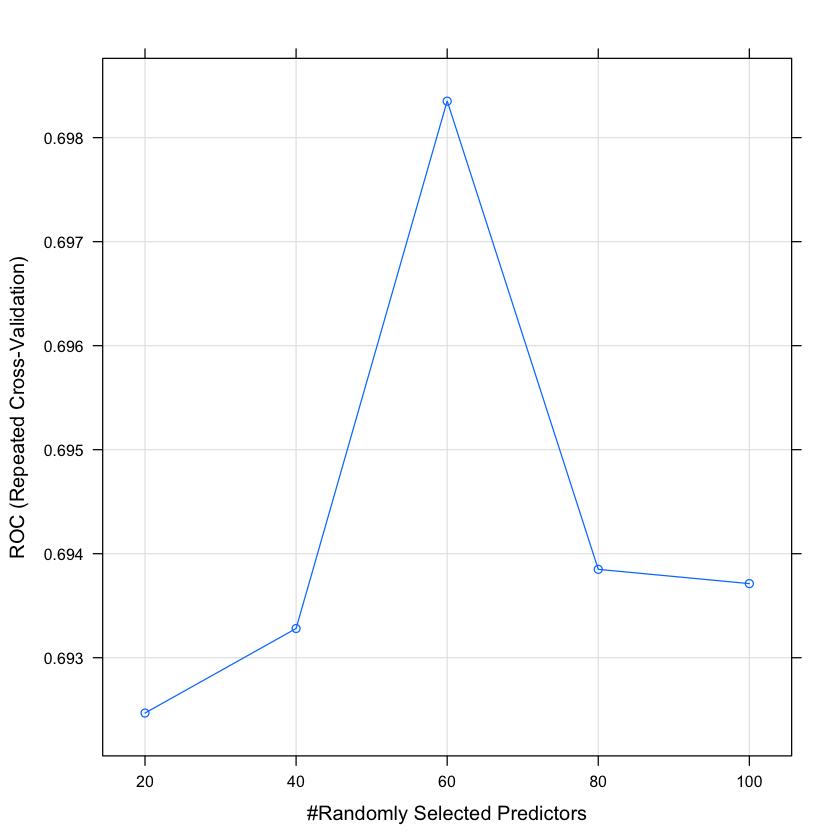

In [32]:
plot(model_rf)

### Training AUC:

In [35]:
pred <- prediction(predict(model_rf$finalModel, airline_train_10k, type = "prob")[,2], airline_train_10k$dep_delayed_15min)
performance(pred,"auc")@y.values[[1]]

[1] 0.7475059

### Test AUC:

In [36]:
pred2 <- prediction(predict(model_rf$finalModel, airline_test_10k, type = "prob")[,2], airline_test_10k$dep_delayed_15min)
performance(pred2,"auc")@y.values[[1]]

[1] 0.6960112

### AUC Curves

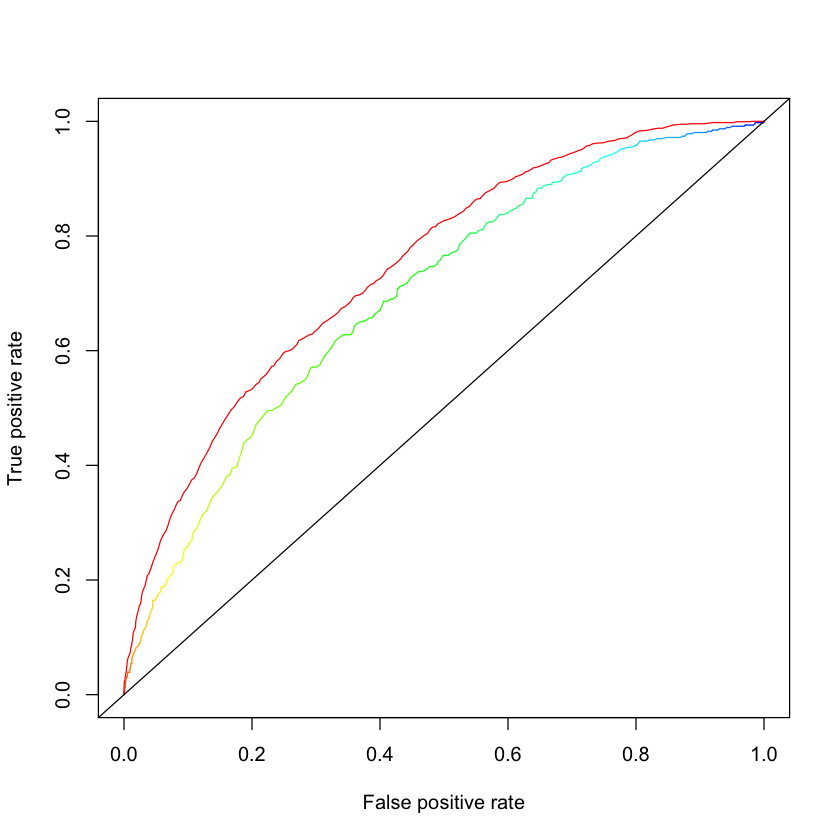

In [38]:
perf <- performance(pred, measure = "tpr", x.measure = "fpr") 
plot(perf, col=rainbow(10))
perf2 <- performance(pred2, measure = "tpr", x.measure = "fpr") 
plot(perf2, add = TRUE, colorize = TRUE)
abline(a=0, b= 1)

### Variable Importance

In [40]:
varImp(model_rf)

rf variable importance

  only 20 most important variables shown (out of 683)

                Importance
DepTime             100.00
DayofMonthc_10       19.96
UniqueCarrierNW      16.91
OriginSJC            16.82
Monthc_4             16.32
DestTYS              15.96
Year                 15.94
Monthc_9             15.38
OriginSAT            15.28
DayOfWeekc_6         15.27
DayofMonthc_8        14.75
Distance             14.66
DayofMonthc_6        14.64
DestHNL              14.54
OriginHNL            14.27
Monthc_12            14.26
UniqueCarrierHA      13.96
OriginIAD            13.64
UniqueCarrierYV      13.47
DestSNA              13.45

## Try 100k full sample the parameters selected in grid search

In [ ]:
myGrid = expand.grid(mtry = c(60))

set.seed(77)
cv_build_fold_idx_final <- createMultiFolds(airlineTrain$dep_delayed_15min, k = 3, times = 1)

model_vars <- names(airlineTrain)[!names(airlineTrain)%in% c('dep_delayed_15min','(Intercept)')]


cvFitControl_final <- trainControl(method = "repeatedcv", repeats = 1, number = 3, index = cv_build_fold_idx_final,
                             classProbs = TRUE, summaryFunction = twoClassSummary, returnResamp = 'all', savePredictions = T,
                             allowParallel= T, verboseIter = T)

start = Sys.time()
model_rf_final <- train(reformulate(model_vars, response="dep_delayed_15min"), data = airlineTrain, metric = "ROC", preProcess = NULL,
                  method = "rf", ntrees = 200, sampsize = c(70,70), tuneGrid = myGrid, trControl = cvFitControl, importance = T)

end = Sys.time()
duration = end - start
print(duration)



[1] "Training AUC: 0.711663561372538"
[1] "Test AUC: 0.703189683004061"


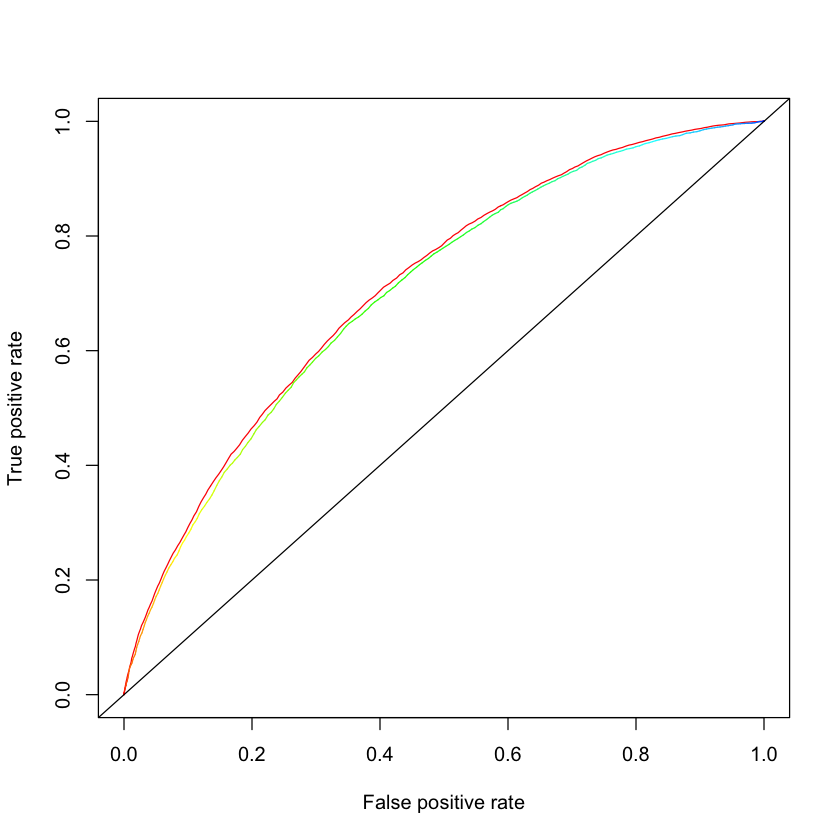

In [46]:
pred_final <- prediction(predict(model_rf_final$finalModel, airlineTrain, type = "prob")[,2], airlineTrain$dep_delayed_15min)
perf_final <- performance(pred_final, measure = "tpr", x.measure = "fpr") 
print(paste0("Training AUC: ",performance(pred_final,"auc")@y.values[[1]]))

pred2_final <- prediction(predict(model_rf_final$finalModel, airlineTest, type = "prob")[,2], airlineTest$dep_delayed_15min)
perf2_final <- performance(pred2_final, measure = "tpr", x.measure = "fpr") 
print(paste0("Test AUC: ",performance(pred2_final,"auc")@y.values[[1]]))

plot(perf_final, col=rainbow(10))
plot(perf2_final, add = TRUE, colorize = TRUE)
abline(a=0, b= 1)

In [50]:
varImp(model_rf_final)

rf variable importance

  only 20 most important variables shown (out of 683)

                Importance
DepTime             100.00
Monthc_9             16.65
Distance             16.35
Monthc_4             15.49
OriginSLC            14.51
DayofMonthc_4        13.84
Monthc_12            13.76
Year                 12.73
DestCVG              12.60
DestSNA              12.25
DestHNL              11.89
OriginORD            11.63
UniqueCarrierHA      11.61
DestSFO              11.49
OriginHNL            10.82
UniqueCarrierNW      10.64
OriginLAS            10.58
OriginHRL            10.56
DestTYS              10.52
DayOfWeekc_5         10.48

In [52]:
pred_val_final <- prediction(predict(model_rf_final$finalModel, airline_vec_2007, type = "prob")[,2], airline_vec_2007$dep_delayed_15min)
perf_val_final <- performance(pred_val_final, measure = "tpr", x.measure = "fpr") 
print(paste0("Validation AUC: ",performance(pred_val_final,"auc")@y.values[[1]]))

[1] "Validation AUC: 0.693164833880881"
